In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from keras import backend as K


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Problema de Regressão com incerteza aleatória

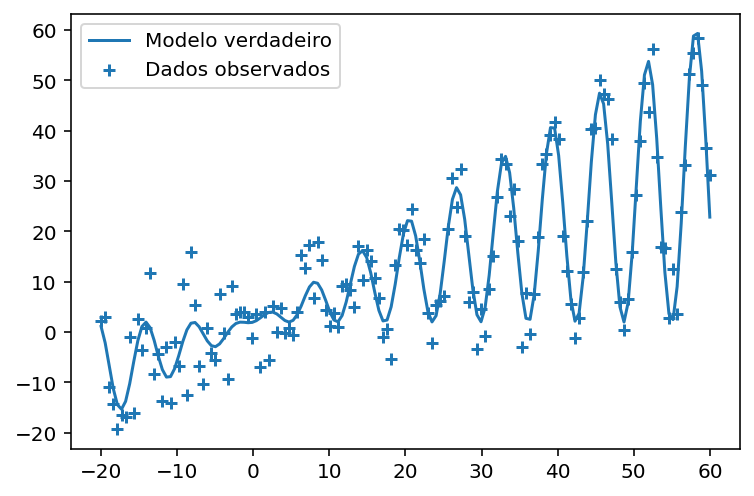

In [3]:
def f(x, sigma):
    np.random.seed(25)
    epsilon = np.random.randn(*x.shape) * sigma
    return  2 + .5 * x * (1. + np.sin(x)) + epsilon

noise = 5

x = np.linspace(-20, 60, 150).reshape(-1, 1)
y = f(x, sigma=noise)
y_true = f(x, sigma=0.0)

plt.scatter(x, y, marker='+', label='Dados observados')
plt.plot(x, y_true, label='Modelo verdadeiro')
plt.legend();

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, input_shape=(1,), activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(2),
    tfp.layers.DistributionLambda(
      lambda t: tfp.distributions.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

negloglik = lambda y, rv_y: -rv_y.log_prob(y)


model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False)

['_TF_MODULE_IGNORED_PROPERTIES', '__abs__', '__abstractmethods__', '__add__', '__and__', '__array_priority__', '__bool__', '__class__', '__delattr__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__invert__', '__iter__', '__le__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rmatmul__', '__rmod__', '__rmul__', '__ror__', '__rpow__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '__xor__', '_abc_impl', '_add_variable_with_custom_getter', '_allow_nan_stats', '_batch_shape', '_batch_shape_tensor', '_call_cdf', '_call_log_cdf', '_call_log_prob', '_call_log_survi

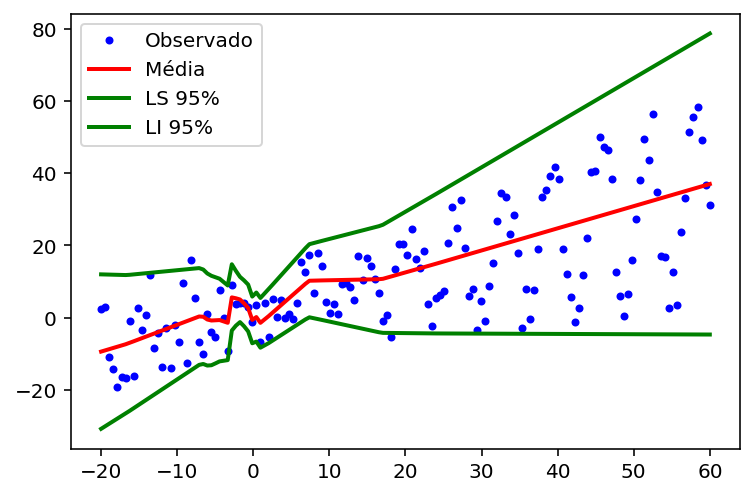

In [6]:
yhat = model(x)
print(dir(yhat))
m = yhat.mean()
s = yhat.stddev()


plt.plot(x, y, 'b.', label='Observado');
plt.plot(x, m, 'r', linewidth=2, label='Média');
plt.plot(x, m + 1.96 * s, 'g', linewidth=2, label=r'LS 95%');
plt.plot(x, m - 1.96 * s, 'g', linewidth=2, label=r'LI 95%');
plt.legend()

## Problema de Regressão Com incerteza aleatória e epistêmica

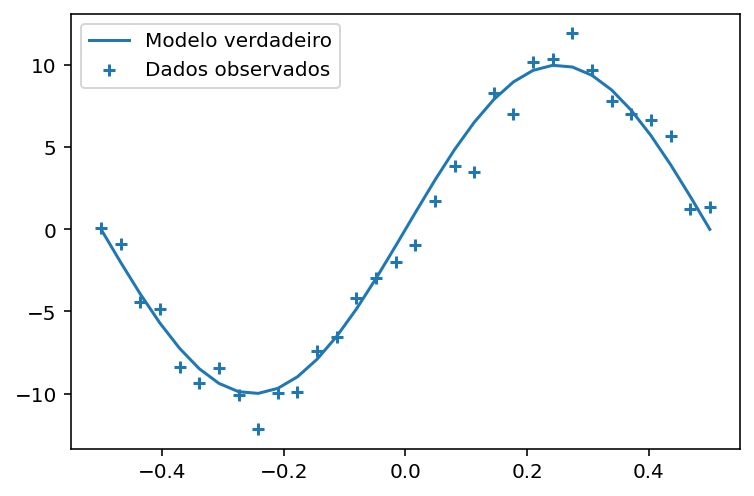

In [5]:
tfd = tfp.distributions

def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return  10 * np.sin(2 * np.pi * (x)) + epsilon

train_size = 32
batch_size = train_size
num_batches = train_size / batch_size
kl_loss_weight = 1.0 / num_batches
noise = 1.0

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)

plt.scatter(X, y, marker='+', label='Dados observados')
plt.plot(X, y_true, label='Modelo verdadeiro')
plt.legend();

In [6]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

  
batch_size = train_size
num_batches = train_size / batch_size
kl_loss_weight = 1.0 / num_batches
  
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def  posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])
  
# Build model.
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tfp.layers.DenseVariational(units=20,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight,
                                activation='relu'),
    tfp.layers.DenseVariational(units=20,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight,
                                activation='relu'),
    tfp.layers.DenseVariational(units=1,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight)
])

In [12]:
from keras import callbacks, optimizers

def neg_log_likelihood(y_true, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_true))

model.compile(loss=neg_log_likelihood, optimizer=tf.optimizers.Adam(learning_rate=0.03), metrics=['mse'])
model.fit(X, y, batch_size=batch_size, epochs=1500, verbose=0)

In [15]:
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
y_pred_list = []
for _ in range(500):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)
y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

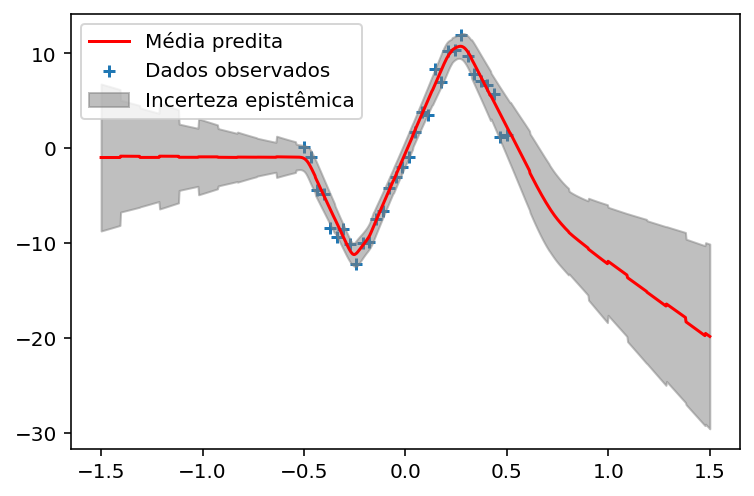

In [16]:
plt.plot(X_test, y_mean, 'r-', label='Média predita');
plt.scatter(X, y, marker='+', label='Dados observados')
plt.fill_between(X_test.ravel(),
                 y_mean + 1.96 * y_sigma,
                 y_mean - 1.96 * y_sigma,
                 alpha=0.5, label='Incerteza epistêmica',
                 color="grey")
plt.legend();